## Importar Librerias

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_toolkits.basemap import Basemap
from nltk.tokenize import word_tokenize
from spacy.matcher import Matcher
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import pandas as pd
import numpy as np
import heapq
import spacy
import nltk
#nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Leer Dataset de noticias de Inmigración desde 2015 hasta hoy en los medios Nacionales

In [495]:
dataset = pd.read_csv("inmigración_chile_2015-01-01_2023-12-31.csv")
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.head(5)

,id_news,country,media_outlet,url,title,text,date,search
0,14206853.0,chile,emol,https://www.emol.com/noticias/Nacional/2016/11...,"Marco Enríquez-Ominami critica a Piñera: ""La i...","SANTIAGO.- ""La inmigración no se puede demoniz...",2016-11-30,inmigración
1,49593944.0,chile,elmostrador,https://www.elmostrador.cl/noticias/pais/2022/...,"61% de las personas encuestadas dice estar ""co...",Durante este jueves el Centro de Estudios Públ...,2022-06-09,inmigración
2,49082552.0,chile,latercera,https://www.latercera.com/politica/noticia/enc...,Encuesta CEP: un 61% de los encuestados asegur...,Este jueves se dio a conocer una nueva versión...,2022-06-09,inmigración
3,49247349.0,chile,cnnchile,https://www.cnnchile.com/mundo/donald-trump-nu...,Trump dice que su plan de inmigración creará u...,"Donald Trump, presidente de Estados Unidos, pr...",2019-05-16,inmigración
4,49581089.0,chile,eldinamo,https://www.eldinamo.cl/mundo/2016/11/11/trump...,Trump recalca que primera medida como presiden...,"Tras ganar las elecciones presidenciales, Dona...",2016-11-11,inmigración


## Imprimimos información del dataset y vemos que no posee valores null o duplicados

In [496]:
print("Filas y columnas del dataset: "+str(dataset.shape))
print()
print(dataset.info())
print()
print("Cantidad de null en cada columnas: " + str(dataset.isnull().sum()))
print()
print("Cantidad de valores duplicados: " + str(dataset.duplicated().sum()))
dataset['date'] = pd.to_datetime(dataset['date'])

Filas y columnas del dataset: (3447, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_news       3447 non-null   float64
 1   country       3447 non-null   object 
 2   media_outlet  3447 non-null   object 
 3   url           3447 non-null   object 
 4   title         3447 non-null   object 
 5   text          3447 non-null   object 
 6   date          3447 non-null   object 
 7   search        3447 non-null   object 
dtypes: float64(1), object(7)
memory usage: 215.6+ KB
None

Cantidad de null en cada columnas: id_news         0
country         0
media_outlet    0
url             0
title           0
text            0
date            0
search          0
dtype: int64

Cantidad de valores duplicados: 0


## Mejoramos los datos:

- Cambiamos a minúscula las columnas 'text'y 'title'.
- Eliminamos espacios en blanco de mas las columnas 'text'y 'title'.
- Cambiamos la columna 'date' a formato fecha.


In [497]:
#dataset['text'] = dataset['text'].str.lower()
#dataset['text'] = dataset['text'].apply(lambda x: x.strip())
#dataset['title'] = dataset['title'].str.lower()
#dataset['title'] = dataset['title'].apply(lambda x: x.strip())
dataset['date'] = pd.to_datetime(dataset['date'])

## Filtramos los datos de la columna 'text' y dejamos las filas que contengan las palabras en keywords

In [498]:
keywords = ["inmigración", "emigración", "ciudadanía", "visas", "permiso de trabajo", "asilo", "refugiados",
            "migrante", "naturalización", "política migratoria", "cruce fronterizo", "control de fronteras",
            "detención migratoria", "deportación", "integración", "documentos de inmigración",
            "reunificación familiar", "programa de lotería de visas", "DREAMers", "políticas de inmigración"]


filtro = dataset['text'].str.lower().str.contains('|'.join(keywords), case=False)
dataset_filtrado = dataset[filtro]
dataset_filtrado.head(5)
dataset.shape

(3447, 8)

## Valores duplicados en ciertas columnas. 

Vemos que existen filas duplicadas en la columnas 'text', esto quiere decir que existen diferentes medios que repiten la misma noticia.

In [504]:
print(dataset_filtrado[dataset_filtrado.duplicated(subset=['title','text'])].shape[0])
print(dataset_filtrado[dataset_filtrado.duplicated(subset=['text'])].shape[0])

0
1


## Preguntas de Análisis

### Cualitativas
¿Cuáles son las principales palabras clave recurrentes en los textos de las noticias de inmigracion?


In [484]:
# Ordenamos el dataset segun su fecha y tomamos los primeros 1000 datos
dataset_filtrado = dataset_filtrado.sort_values('date').reset_index()[0:1000]

In [485]:
#Procesamos los datos para responder la pregunta

# Obtener stopwords en español
stop_words = set(stopwords.words('spanish'))

# Concatenar todos los textos de las noticias de incendios forestales
textos = ' '.join(dataset_filtrado['text'])

# Tokenizar los textos en palabras
tokens = word_tokenize(textos)

# Filtrar palabras que no sean stopwords y que tengan más de 2 caracteres
filtered_words = [word.lower() for word in tokens if word.lower() not in stop_words and len(word) > 2]

# Calcular la frecuencia de las palabras
word_freq = Counter(filtered_words)

# Obtener las 10 palabras más frecuentes
top_keywords = word_freq.most_common(10)

keywords = [keyword for keyword, _ in top_keywords]
frequencies = [frequency for _, frequency in top_keywords]

### Gráficamos las palabras y su frecuencia, para podeer responder a la pregunta

<Axes: xlabel='Keywords', ylabel='Frecuencia'>

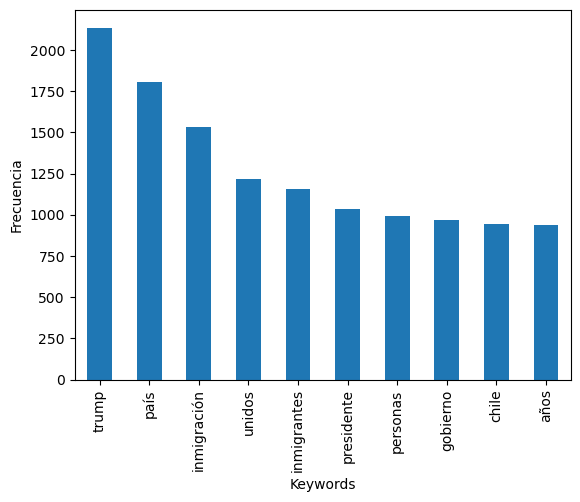

In [487]:
df_key = pd.DataFrame({'Keywords':keywords,'Frecuencia':frequencies})
df_key.plot(x='Keywords',ylabel = 'Frecuencia', kind='bar',legend=False)

### Cuantitativas
- ¿Cuántas noticias de inmigracion se publicaron en cada medio de comunicación (media_outlet)?
- ¿Cuál es la distribución de noticias de inmigracion por fecha? 

<Axes: xlabel='Medios', ylabel='Frecuencia'>

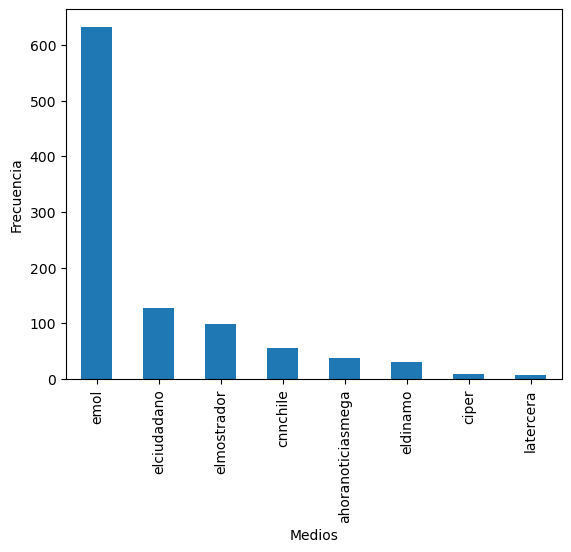

In [488]:
# Obtenemos la cantidad de noticias sobre incendio que publica cada medio y gráficamos
media_count = dataset_filtrado['media_outlet'].value_counts()

media_count.plot(kind = 'bar',xlabel='Medios',ylabel='Frecuencia')

<Axes: xlabel='Fecha', ylabel='Numero de noticias'>

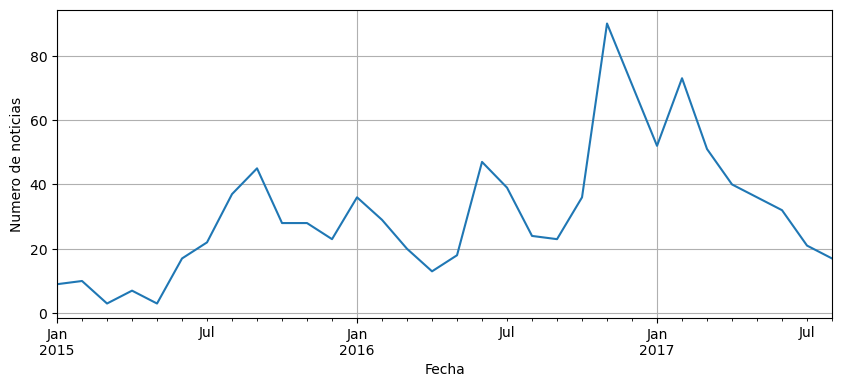

In [489]:
# Buscamos la cantidad de noticias publicadas mensualemente 
noticias_por_mes = dataset_filtrado.groupby(dataset_filtrado['date'].dt.to_period('M')).size()

#Gráficamos
noticias_por_mes.plot(xlabel='Fecha',ylabel='Numero de noticias',grid=True,figsize=(10,4))

## Análisis de series temporales

Suavizamos la cantidad de noticias en función del tiempo

<Axes: xlabel='Fecha', ylabel='Numero de noticias'>

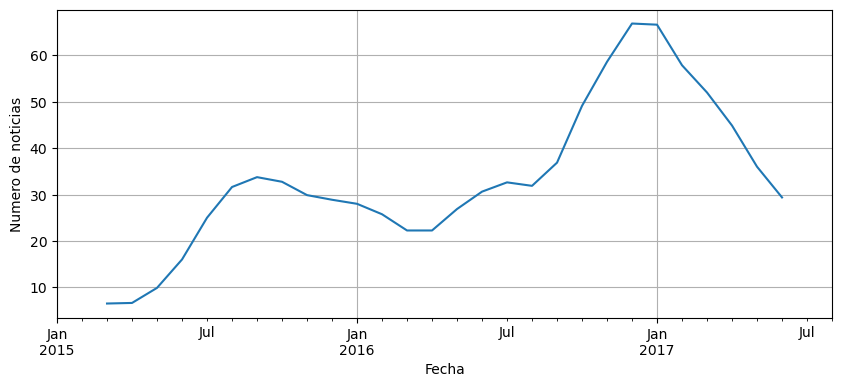

In [490]:
decomposition = seasonal_decompose(noticias_por_mes, model='additive', period=4)

decomposition.trend.plot(xlabel='Fecha',ylabel='Numero de noticias',grid=True,figsize=(10,4))

## Hipotesis
## Aun no estoy seguro de la hipotesis :c
"La cobertura mediatica de la migracion en chile se centra principalmente en paises cercanos geograficamente."


## Que espero?

/tmp/ipykernel_5947/2778233886.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


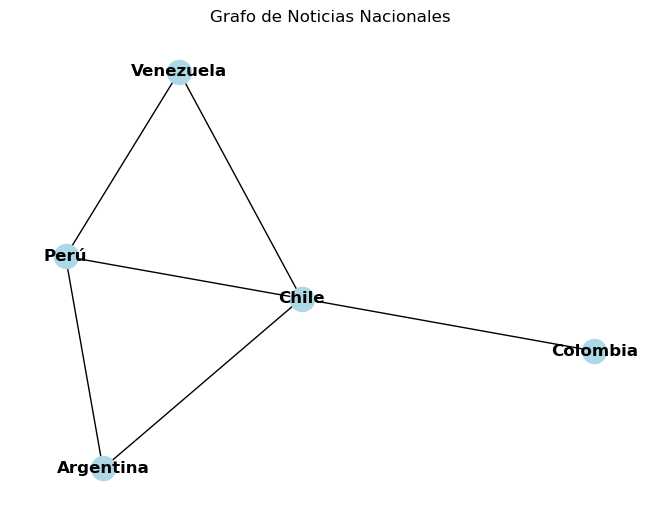

In [527]:
import networkx as nx
noticias_nacionales = pd.DataFrame([
    {"noticia_id": 1, "países": ["Chile", "Argentina", "Perú"]},
    {"noticia_id": 2, "países": ["Chile", "Colombia"]},
    {"noticia_id": 5, "países": ["Chile", "Venezuela", "Perú"]},
     {"noticia_id": 6, "países": ["Chile"]},
  
])


G_nacional = nx.Graph()

for _, noticia in noticias_nacionales.iterrows():
    países = noticia["países"]
    G_nacional.add_nodes_from(países)
    G_nacional.add_edges_from([(países[i], países[j]) for i in range(len(países)) for j in range(i+1, len(países))])

nx.draw(G_nacional, with_labels=True, node_color="lightblue", font_weight="bold")
plt.title("Grafo de Noticias Nacionales")

plt.tight_layout()
plt.show()

Tomamos los datos unicamente del 2016

In [521]:
df_date = dataset_filtrado[dataset_filtrado['date'].dt.year == 2016].reset_index()

Filtramos las localizaciones que se mencionan en las noticias

In [522]:
GEO = []

for i in range(0,len(df_date)):
    text = df_date.text[i]
    doc = nlp(text)
    news = []
    for ent in doc.ents:
        if ent.label_=='LOC':
            news.append(ent.text)
    lugares = list(set(news))
    lugares_validos = []
    for lugar in lugares:
        if len(lugar.split()) <= 2 and lugar[0].isupper():
            lugares_validos.append(lugar)
    
    GEO.append(lugares_validos)
    
df_date['paises'] = GEO
flat_GEO = [item for sublist in GEO for item in sublist]

Graficamos la frecuencia de las localizaciones mas mencionadas

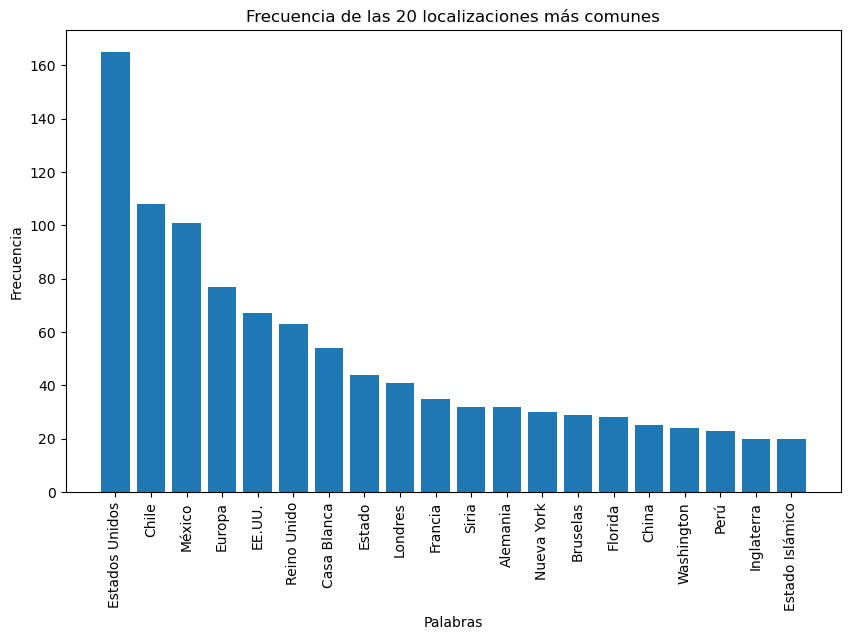

In [596]:
word_count = Counter(flat_GEO)

words = []
frequencies = []
top_n = 20 

for word, frequency in word_count.most_common(top_n):
    words.append(word)
    frequencies.append(frequency)

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de las {} localizaciones más comunes'.format(top_n))
plt.xticks(rotation=90)
plt.show()


Leemos un dataset que cuenta con los nombres de todos los paises del mundo y filtramos nuestros datos que no se encuentren en el dataset

In [529]:
df_paises = pd.read_csv('paises.csv')
paises= df_paises['Pais'].tolist()

def filtrar_paises(row):
    paises_filtrados = [pais for pais in row if pais in paises]
    return paises_filtrados

df_date['paises_filtrados'] = df_date['paises'].apply(filtrar_paises)
df_network = df_date[df_date['paises_filtrados'].apply(lambda x: len(x) > 1)][['id_news','paises_filtrados']]
df_network.head()

,id_news,paises_filtrados
2,15141440.0,"[Sudán, Pakistán, Reino Unido, Eritrea, Siria,..."
4,15110697.0,"[Reino Unido, Australia]"
5,14207091.0,"[México, Estados Unidos, Chile]"
8,14206340.0,"[Francia, Chile]"
14,7211428.0,"[Estados Unidos, México]"


Graficamos nuevamente la frecuencia de los paises pero ahora con los datos filtrados

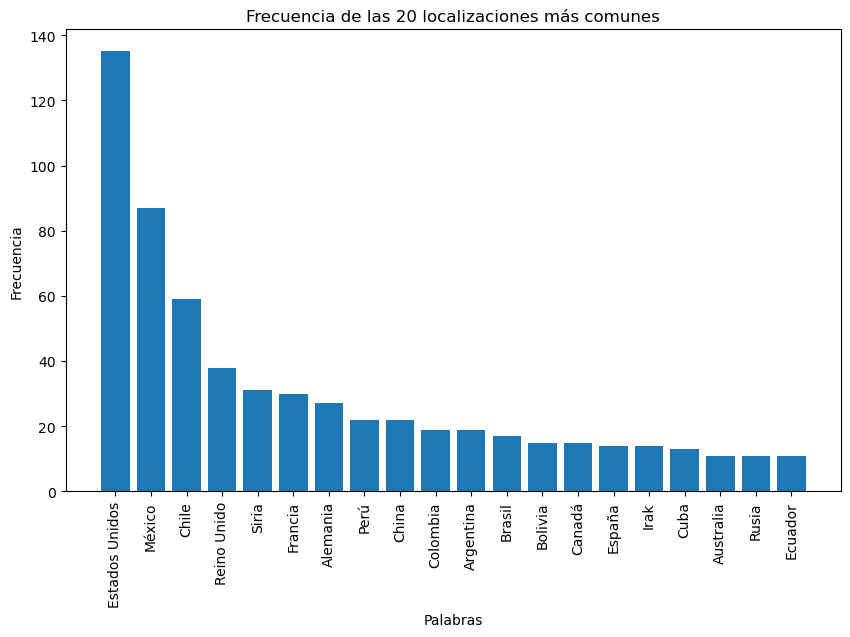

In [597]:
flat = [item for sublist in df_network['paises_filtrados'].tolist() for item in sublist]
word_count = Counter(flat)

words = []
frequencies = []
top_n = 20 

for word, frequency in word_count.most_common(top_n):
    words.append(word)
    frequencies.append(frequency)

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de las {} localizaciones más comunes'.format(top_n))
plt.xticks(rotation=90)
plt.show()

Creamos un grafo ponderado de los datos, aumentando el "peso" si mas de una noticia menciona al mismo par (o mas) de paises.

/home/cristian/anaconda3/envs/NLP/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


(-1.145021978295104,
 0.5261836763437155,
 -0.7889855259169422,
 0.36233548133713966)

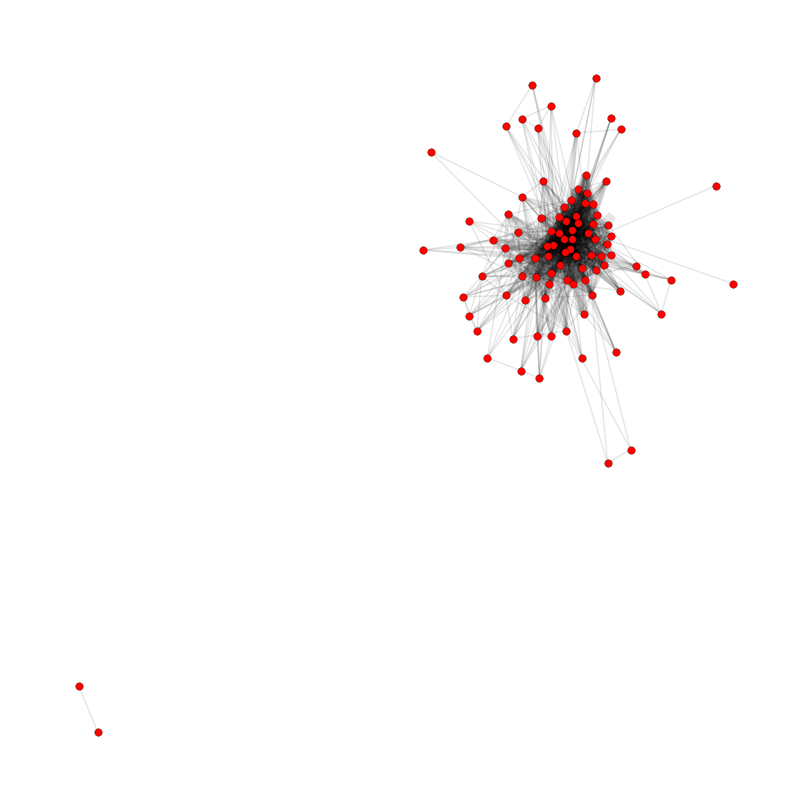

In [549]:
G = nx.Graph()

for _, row in df_network.iterrows():
    paises = row['paises_filtrados']
    for i in range(len(paises)):
        for j in range(i + 1, len(paises)):
            peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
            G.add_edge(paises[i], paises[j], weight=peso)
            
labels = nx.get_edge_attributes(G,'weight')            
fig, axs = plt.subplots(figsize=(8,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
pos = nx.layout.circular_layout(G)
pos = nx.spring_layout(G, pos=pos, k=0.7, iterations=100, seed=0)
sc = nx.draw_networkx_nodes(G, pos, linewidths=0.2, node_color='red', edgecolors='black', ax=axs, cmap='Spectral_r', node_size=30)
nx.draw_networkx_edges(G, pos, width=list(labels.values()), ax=axs,alpha=0.1)
axs.axis('off')

Vemos las componentes

In [534]:
S_bin = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print("Number of nodes per component:")
np.array([len(S_bin[i]) for i in range(len(S_bin))])

Number of nodes per component:


array([94,  2])

Seleccionamos la primera componente (la conexion deberia ser mas gruesa segun la ponderacion sea mayor pero no se dinstingue muy bien)

In [535]:
component = 0
pos = nx.layout.circular_layout(S_bin[component])
pos = nx.spring_layout(S_bin[component], pos=pos, k=0.35, iterations=100, seed=0)

(-0.9387809423869026,
 1.1842280533489815,
 -1.0829924818159058,
 0.9504466375689339)

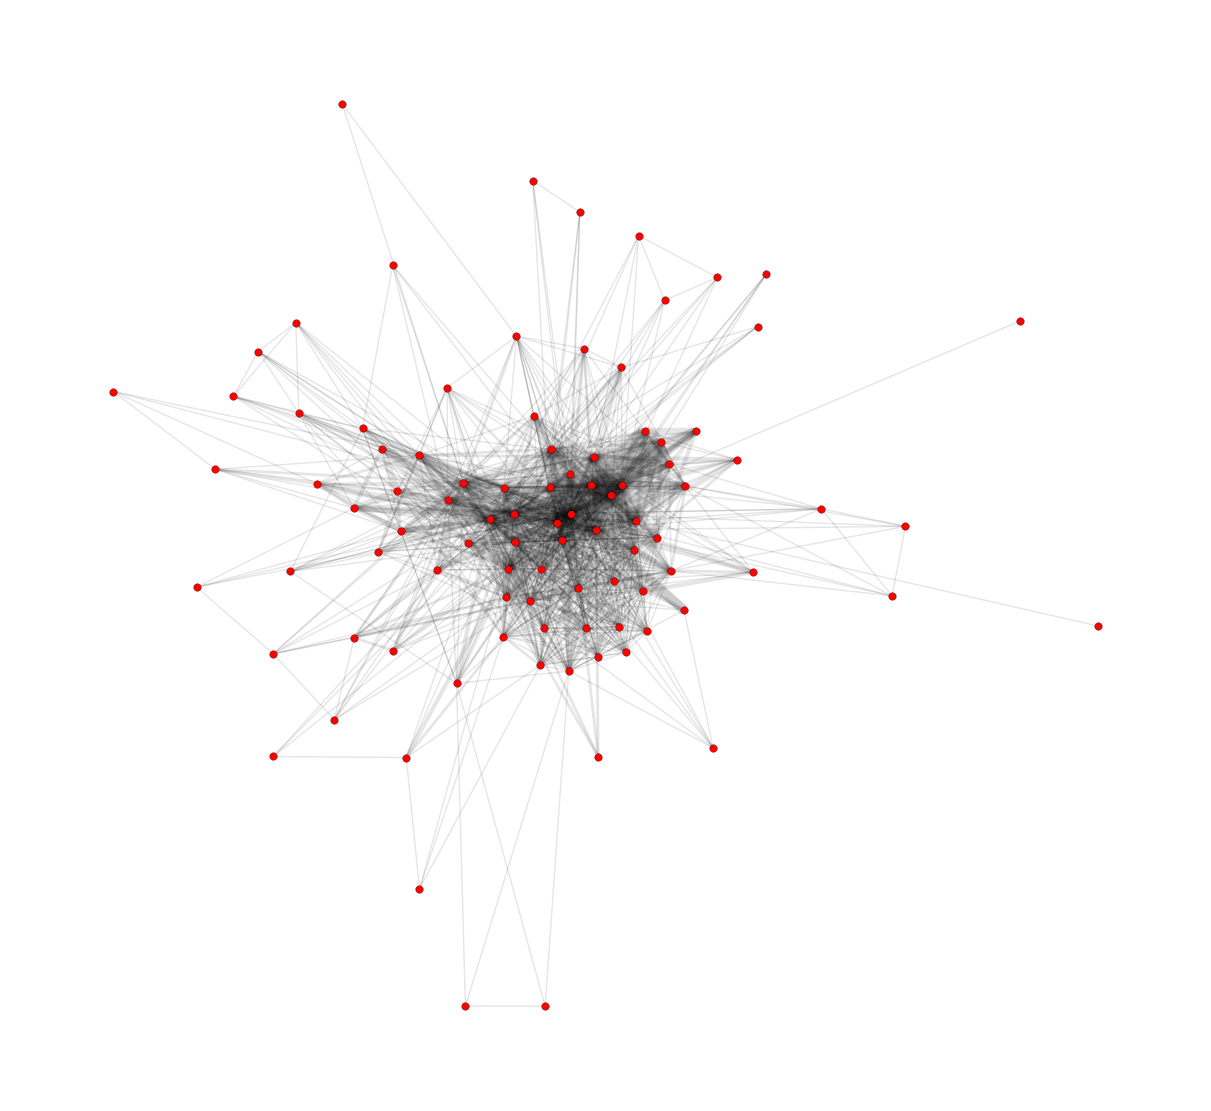

In [546]:
labels = nx.get_edge_attributes(S_bin[component],'weight')            
fig, axs = plt.subplots(figsize=(12,11), facecolor='w', nrows=1, ncols=1, constrained_layout=True)

sc = nx.draw_networkx_nodes(S_bin[component], pos, linewidths=0.2, node_color='red', edgecolors='black', ax=axs, cmap='Spectral_r', node_size=30)
nx.draw_networkx_edges(S_bin[component], pos, width=list(labels.values()), ax=axs,alpha=0.1)
axs.axis('off')

Visualizamos el deegree centrality

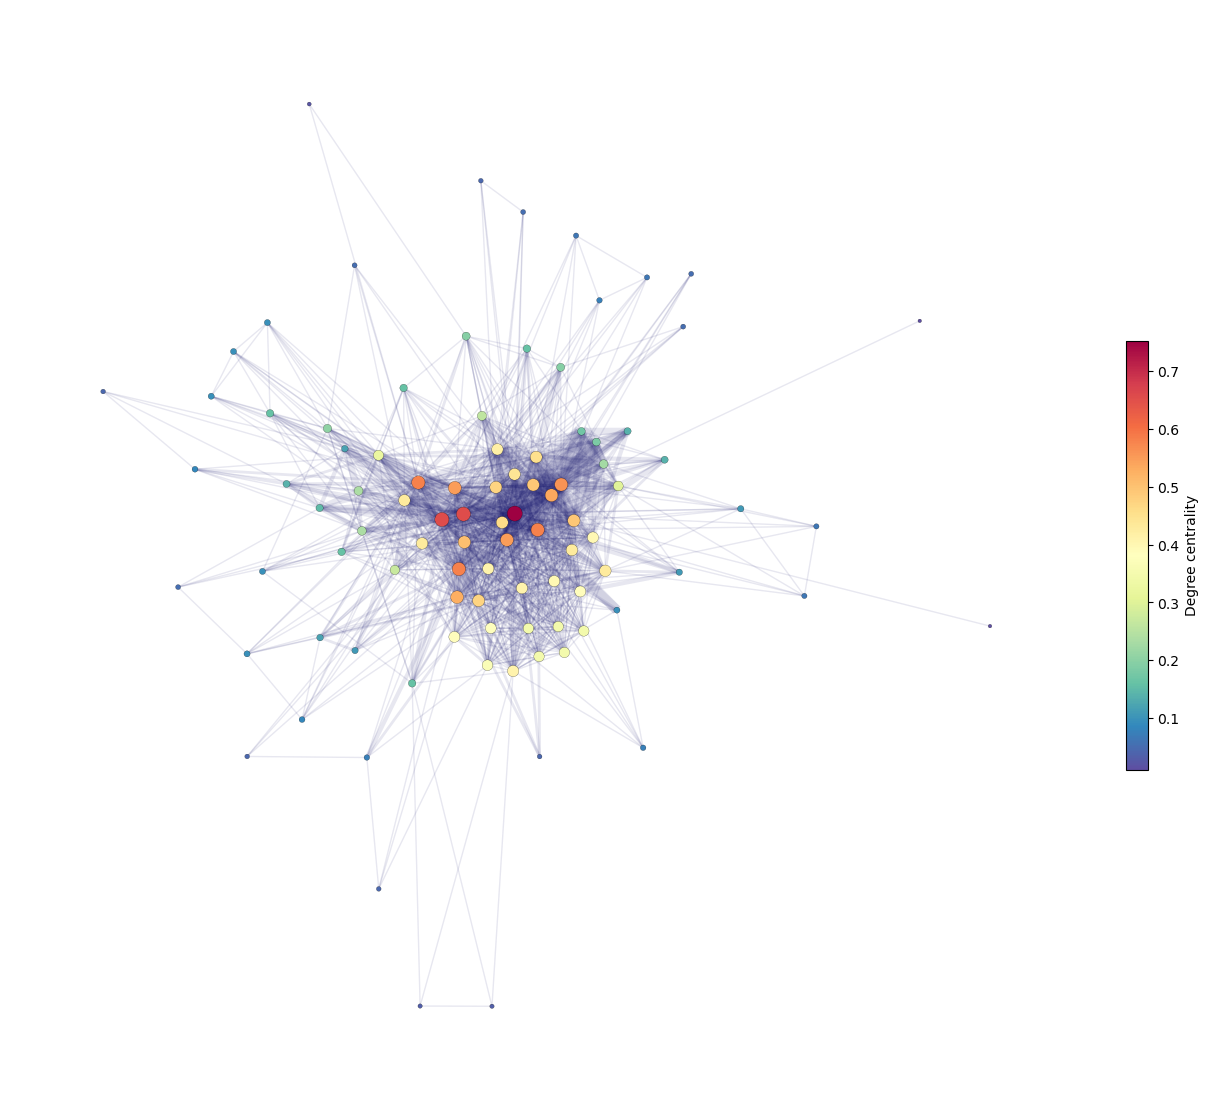

In [539]:
labels = nx.get_edge_attributes(S_bin[component],'weight')   
node_color = degree_centrality # np.log(degree_centrality) 
fig, axs = plt.subplots(figsize=(12,11), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
sc = nx.draw_networkx_nodes(S_bin[component], pos, linewidths=0.15, node_color=node_color, edgecolors='k', ax=axs, cmap='Spectral_r', node_size=5.+(150*node_color))
nx.draw_networkx_edges(S_bin[component], pos, edge_color='midnightblue', alpha=0.1, width=list(labels.values()), ax=axs)
axs.axis('off')
cbar=plt.colorbar(sc, ax=axs,fraction=0.02, pad=0.04)
cbar.set_label("Degree centrality")

Vemos los 10 paises con mayor degree centrality, closeness centrality, betweenness centrality y
eigenvector centrality

In [540]:
number_centrality = 10
degree_centrality = nx.degree_centrality(S_bin[component])
degree_centrality_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:number_centrality]

closeness_centrality = nx.closeness_centrality(S_bin[component])
closeness_centrality_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:number_centrality]

betweenness_centrality = nx.betweenness_centrality(S_bin[component])
betweenness_centrality_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:number_centrality]

eigenvector_centrality = nx.eigenvector_centrality(S_bin[component])
eigenvector_centrality_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:number_centrality]

In [541]:
df_centrality = pd.DataFrame({'degree_centrality':degree_centrality_nodes,
'closeness_centrality':closeness_centrality_nodes,'betweenness_centrality':betweenness_centrality_nodes,
                              'eigenvector_centrality':eigenvector_centrality_nodes })
df_centrality

,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,Estados Unidos,Estados Unidos,Estados Unidos,Estados Unidos
1,Francia,Francia,Siria,Francia
2,Alemania,Alemania,Alemania,Alemania
3,Reino Unido,Reino Unido,Francia,Perú
4,Siria,Siria,Reino Unido,México
5,México,México,México,Colombia
6,Colombia,Colombia,Israel,Ucrania
7,España,España,Argentina,España
8,Ucrania,Ucrania,Colombia,Reino Unido
9,Perú,Perú,Ucrania,Rusia


Mostramos los paises con conexiones con mayor peso

In [599]:
G_map = nx.Graph()
pais_location = []
weights = nx.get_edge_attributes(G, "weight")

top_10_edges = heapq.nlargest(20, weights.items(), key=lambda x: x[1])
print("Las 20 conexiones con mayor peso son:")
for edge, weight in top_10_edges:
    pais1, pais2 = edge
    print(f"{pais1} - {pais2}: {weight}")
    G_map.add_edge(pais1, pais2, weight=weight)
    pais_location.append([pais1,pais2])


Las 20 conexiones con mayor peso son:
México - Estados Unidos: 78
Estados Unidos - Chile: 27
Chile - Perú: 18
Chile - Colombia: 16
Reino Unido - Estados Unidos: 15
Estados Unidos - China: 15
Chile - Bolivia: 14
Siria - Estados Unidos: 13
Colombia - Perú: 13
Siria - Irak: 12
México - Chile: 12
Estados Unidos - Canadá: 12
Estados Unidos - Alemania: 12
Chile - Argentina: 12
Francia - Alemania: 12
Estados Unidos - Francia: 11
Chile - Ecuador: 11
Bolivia - Perú: 11
Reino Unido - Francia: 10
Estados Unidos - España: 10


Obtenemos la coordenadas de los paises anteriormente mencionados

In [593]:
paises_location = np.unique([item for sublist in pais_location for item in sublist])
geolocator = Nominatim(user_agent="my_app")
coordenadas = {}
for pais in paises_location:
    location = geolocator.geocode(pais)
    coordenadas[pais] = (location.latitude, location.longitude)

Graficamos las conexiones de los 20 paises con mayor peso, el tamaño de la linea es segun el peso.

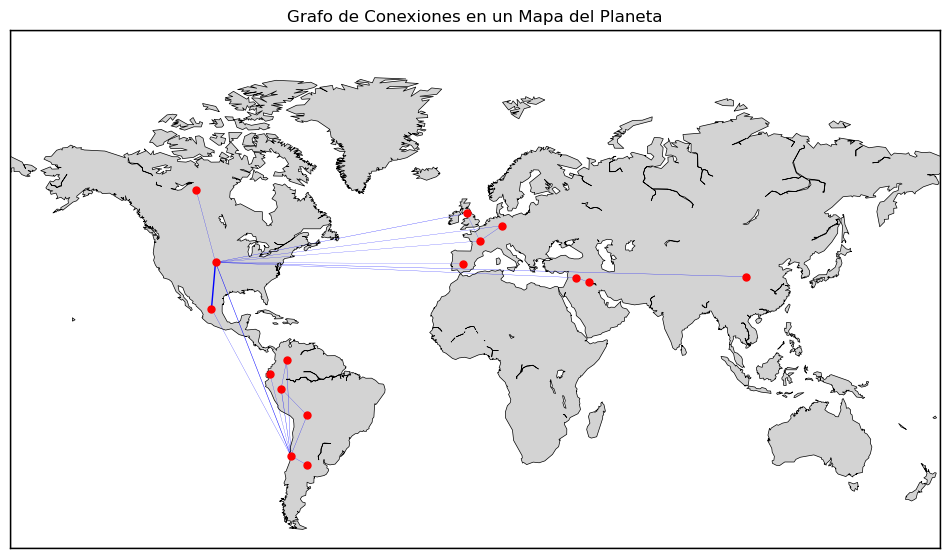

In [594]:
fig = plt.figure(figsize=(12, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(G_map,'weight') 

pos = {}
for country in coordenadas:
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'ro', markersize=5)
    
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [weight / max_weight for weight in weights]

nx.draw_networkx_edges(G_map, pos, width=normalized_weights, alpha=1, edge_color='b', arrows=False)

plt.title("Grafo de Conexiones en un Mapa del Planeta")
plt.show()